## Generalized graph generation procedure

- No need to specify entity types in `.tl.gen_graph()` any more
- Entities and relations are matched automatically between anndata objects
- Easily extend to new single-cell modalities

In [1]:
import os
import simba as si
si.__version__

'1.2'

In [2]:
si.settings.set_figure_params(dpi=80,
                              style='white',
                              fig_size=[5,5],
                              rc={'image.cmap': 'viridis'})

In [3]:
# make plots prettier
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')

### scRNA-seq analysis

In [4]:
workdir = 'result_new_graph_generation/scRNAseq'
si.settings.set_workdir(workdir)

Saving results in: result_new_graph_generation/scRNAseq


In [5]:
adata_CG = si.datasets.rna_10xpmbc3k()
si.pp.filter_genes(adata_CG,min_n_cells=3)
si.pp.cal_qc_rna(adata_CG)
si.pp.normalize(adata_CG,method='lib_size')
si.pp.log_transform(adata_CG)
si.pp.select_variable_genes(adata_CG, n_top_genes=2000)

rna_10xpmbc3k.h5ad: 21.5MB [00:03, 5.45MB/s]                                               


Downloaded to result_new_graph_generation/scRNAseq/data.
Before filtering: 
2700 cells, 32738 genes
Filter genes based on min_n_cells
After filtering out low-expressed genes: 
2700 cells, 13714 genes
2000 variable genes are selected.


In [6]:
# keep only variable genes
adata_CG_fltr = adata_CG[:, adata_CG.var['highly_variable']].copy()

si.tl.gen_graph(list_adata=[adata_CG_fltr],
                copy=False,
                add_edge_weights=True,
                dirname='graph0')

`simba` does not exist in adata 0 in `list_adata`.`.X` is being used instead.
relation0: source: E0, destination: E1
#edges: 509430
Total number of edges: 509430
Writing graph file "pbg_graph.txt" to "result_new_graph_generation/scRNAseq/pbg/graph0" ...
Finished.


In [7]:
# modify parameters
dict_config = si.settings.pbg_params.copy()
dict_config['wd_interval'] = 10 # we usually set `wd_interval` to 10 for scRNA-seq datasets for a slower but finer training
dict_config['workers'] = 4 #The number of CPUs.

## start training
si.tl.pbg_train(pbg_params = dict_config, auto_wd=True, save_wd=True, output='model', use_edge_weights=True)

Auto-estimated weight decay is 0.069558
`.settings.pbg_params['wd']` has been updated to 0.069558
Converting input data ...
Edge weights are being used ...
[2022-10-10 15:29:26.273437] Using the 1 relation types given in the config
[2022-10-10 15:29:26.273982] Searching for the entities in the edge files...
[2022-10-10 15:29:27.014368] Entity type E0:
[2022-10-10 15:29:27.015074] - Found 2700 entities
[2022-10-10 15:29:27.015471] - Removing the ones with fewer than 1 occurrences...
[2022-10-10 15:29:27.016342] - Left with 2700 entities
[2022-10-10 15:29:27.016984] - Shuffling them...
[2022-10-10 15:29:27.019567] Entity type E1:
[2022-10-10 15:29:27.020450] - Found 2000 entities
[2022-10-10 15:29:27.020810] - Removing the ones with fewer than 1 occurrences...
[2022-10-10 15:29:27.021417] - Left with 2000 entities
[2022-10-10 15:29:27.021901] - Shuffling them...
[2022-10-10 15:29:27.023654] Preparing counts and dictionaries for entities and relation types:
[2022-10-10 15:29:27.024809] - 

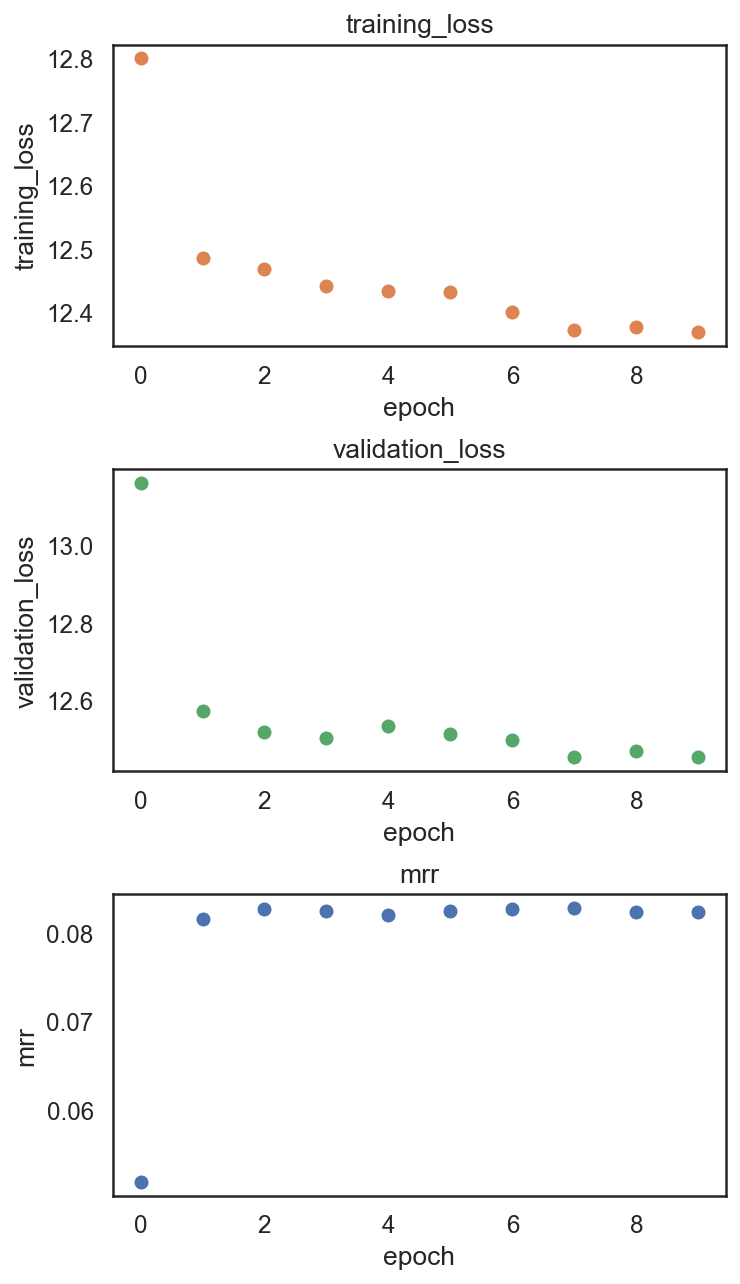

In [8]:
si.pl.pbg_metrics(fig_ncol=1)

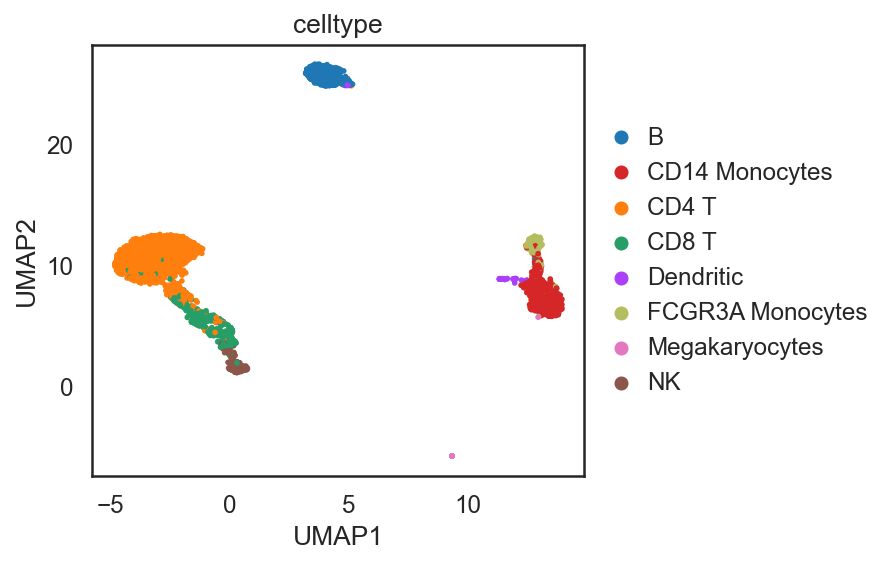

In [9]:
palette_celltype={'B':'#1f77b4',
                  'CD4 T':'#ff7f0e',
                  'CD8 T':'#279e68',
                  'Dendritic':"#aa40fc",
                  'CD14 Monocytes':'#d62728',
                  'FCGR3A Monocytes':'#b5bd61',
                  'Megakaryocytes':'#e377c2',
                  'NK':'#8c564b'}

dict_adata = si.read_embedding()

adata_C = dict_adata['E0']  # embeddings for cells
adata_G = dict_adata['E1']  # embeddings for genes

## Add annotation of celltypes (optional)
adata_C.obs['celltype'] = adata_CG[adata_C.obs_names,:].obs['celltype'].copy()
si.tl.umap(adata_C,n_neighbors=15,n_components=2)
si.pl.umap(adata_C,color=['celltype'],
           dict_palette={'celltype': palette_celltype},
           fig_size=(6,4),
           drawing_order='random')

### Batch correction (two batches)

In [10]:
workdir = 'result_new_graph_generation/batch_correction_two'
si.settings.set_workdir(workdir)

Saving results in: result_new_graph_generation/batch_correction_two


In [11]:
# mirowell-seq data
adata_CG_mi = si.datasets.rna_han2018()
# smart-seq data
adata_CG_sm = si.datasets.rna_tmc2018()

rna_han2018.h5ad: 24.6MB [00:04, 5.74MB/s]                                                 


Downloaded to result_new_graph_generation/batch_correction_two/data.


rna_tmc2018.h5ad: 50.9MB [00:07, 7.07MB/s]                                                 


Downloaded to result_new_graph_generation/batch_correction_two/data.


In [12]:
adata_CG_mi

AnnData object with n_obs × n_vars = 4239 × 15006
    obs: 'nGene', 'nUMI', 'orig.ident', 'batch', 'ct', 'ct.orig', 'tissue', 'organ', 'percent.mito', 'batchlb', 'celltype'

In [13]:
adata_CG_sm

AnnData object with n_obs × n_vars = 2715 × 15006
    obs: 'nGene', 'nUMI', 'orig.ident', 'batch', 'ct', 'ct.orig', 'tissue', 'organ', 'percent.mito', 'batchlb', 'celltype'

In [14]:
# microwell-seq data
si.pp.filter_genes(adata_CG_mi,min_n_cells=3)
si.pp.cal_qc_rna(adata_CG_mi)
si.pp.normalize(adata_CG_mi,method='lib_size')
si.pp.log_transform(adata_CG_mi)
si.pp.select_variable_genes(adata_CG_mi, n_top_genes=3000)

Before filtering: 
4239 cells, 15006 genes
Filter genes based on min_n_cells
After filtering out low-expressed genes: 
4239 cells, 13662 genes
3000 variable genes are selected.


In [15]:
# smart-seq2 data
si.pp.filter_genes(adata_CG_sm,min_n_cells=3)
si.pp.cal_qc_rna(adata_CG_sm)
si.pp.normalize(adata_CG_sm,method='lib_size')
si.pp.log_transform(adata_CG_sm)
si.pp.select_variable_genes(adata_CG_sm, n_top_genes=3000)

Before filtering: 
2715 cells, 15006 genes
Filter genes based on min_n_cells
After filtering out low-expressed genes: 
2715 cells, 14956 genes
3000 variable genes are selected.


In [16]:
# infer edges between cells of different technologies
adata_CmiCsm = si.tl.infer_edges(adata_CG_mi, adata_CG_sm, n_components=20, k=20)
# edges can be futhere trimmed if needed. Here we keep all of them
si.tl.trim_edges(adata_CmiCsm, cutoff=0.5)

# The range of similary scores is 0-1. We multipled them by 10 to give higher weights to relation between cells
adata_CmiCsm.X = adata_CmiCsm.X*10

#shared features: 2969
Performing randomized SVD ...
Searching for mutual nearest neighbors ...
27952 edges are selected
27952 edges are selected


/Users/huidong/anaconda3/envs/env_simba_dev/lib/python3.10/site-packages/simba/tools/_integration.py:142: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_ref_query = ad.AnnData(X=sim_ref_query,


In [17]:
adata_CmiCsm

AnnData object with n_obs × n_vars = 4239 × 2715
    obs: 'nGene', 'nUMI', 'orig.ident', 'batch', 'ct', 'ct.orig', 'tissue', 'organ', 'percent.mito', 'batchlb', 'celltype', 'n_counts', 'n_genes', 'pct_genes', 'pct_mt'
    var: 'nGene', 'nUMI', 'orig.ident', 'batch', 'ct', 'ct.orig', 'tissue', 'organ', 'percent.mito', 'batchlb', 'celltype', 'n_counts', 'n_genes', 'pct_genes', 'pct_mt'
    obsm: 'svd'
    varm: 'svd'
    layers: 'simba'

In [18]:
# keep only variable genes
adata_CG_mi_fltr = adata_CG_mi[:, adata_CG_mi.var['highly_variable']].copy()
adata_CG_sm_fltr = adata_CG_sm[:, adata_CG_sm.var['highly_variable']].copy()

si.tl.gen_graph(list_adata=[adata_CG_mi_fltr, adata_CG_sm_fltr, adata_CmiCsm],
                copy=False,
                layer=None,
                dirname='graph2')

relation0: source: E0, destination: E1
#edges: 550497
relation1: source: E2, destination: E1
#edges: 773587
relation2: source: E0, destination: E2
#edges: 27952
Total number of edges: 1352036
Writing graph file "pbg_graph.txt" to "result_new_graph_generation/batch_correction_two/pbg/graph2" ...
Finished.


In [19]:
si.settings.pbg_params

{'entity_path': 'result_new_graph_generation/batch_correction_two/pbg/graph2/input/entity',
 'edge_paths': ['result_new_graph_generation/batch_correction_two/pbg/graph2/input/edge'],
 'checkpoint_path': '',
 'entities': {'E0': {'num_partitions': 1},
  'E1': {'num_partitions': 1},
  'E2': {'num_partitions': 1}},
 'relations': [{'name': 'r0',
   'lhs': 'E0',
   'rhs': 'E1',
   'operator': 'none',
   'weight': 1.0},
  {'name': 'r1', 'lhs': 'E2', 'rhs': 'E1', 'operator': 'none', 'weight': 1.0},
  {'name': 'r2', 'lhs': 'E0', 'rhs': 'E2', 'operator': 'none', 'weight': 1.0}],
 'dynamic_relations': False,
 'dimension': 50,
 'global_emb': False,
 'comparator': 'dot',
 'num_epochs': 10,
 'workers': 4,
 'num_batch_negs': 50,
 'num_uniform_negs': 50,
 'loss_fn': 'softmax',
 'lr': 0.1,
 'early_stopping': False,
 'regularization_coef': 0.0,
 'wd': 0.0,
 'wd_interval': 50,
 'eval_fraction': 0.05,
 'eval_num_batch_negs': 50,
 'eval_num_uniform_negs': 50,
 'checkpoint_preservation_interval': None}

In [20]:
# modify parameters
dict_config = si.settings.pbg_params.copy()
# dict_config['wd'] = 0.026209
dict_config['workers'] = 4

## start training
si.tl.pbg_train(pbg_params = dict_config, auto_wd=True, save_wd=True, output='model', use_edge_weights=True)

Auto-estimated weight decay is 0.026209
`.settings.pbg_params['wd']` has been updated to 0.026209
Converting input data ...
Edge weights are being used ...
[2022-10-10 15:30:17.233560] Using the 3 relation types given in the config
[2022-10-10 15:30:17.234069] Searching for the entities in the edge files...
[2022-10-10 15:30:19.057184] Entity type E0:
[2022-10-10 15:30:19.057731] - Found 4239 entities
[2022-10-10 15:30:19.058159] - Removing the ones with fewer than 1 occurrences...
[2022-10-10 15:30:19.059129] - Left with 4239 entities
[2022-10-10 15:30:19.059906] - Shuffling them...
[2022-10-10 15:30:19.062890] Entity type E1:
[2022-10-10 15:30:19.063783] - Found 4620 entities
[2022-10-10 15:30:19.064333] - Removing the ones with fewer than 1 occurrences...
[2022-10-10 15:30:19.065608] - Left with 4620 entities
[2022-10-10 15:30:19.066450] - Shuffling them...
[2022-10-10 15:30:19.069455] Entity type E2:
[2022-10-10 15:30:19.070294] - Found 2715 entities
[2022-10-10 15:30:19.070697] - 

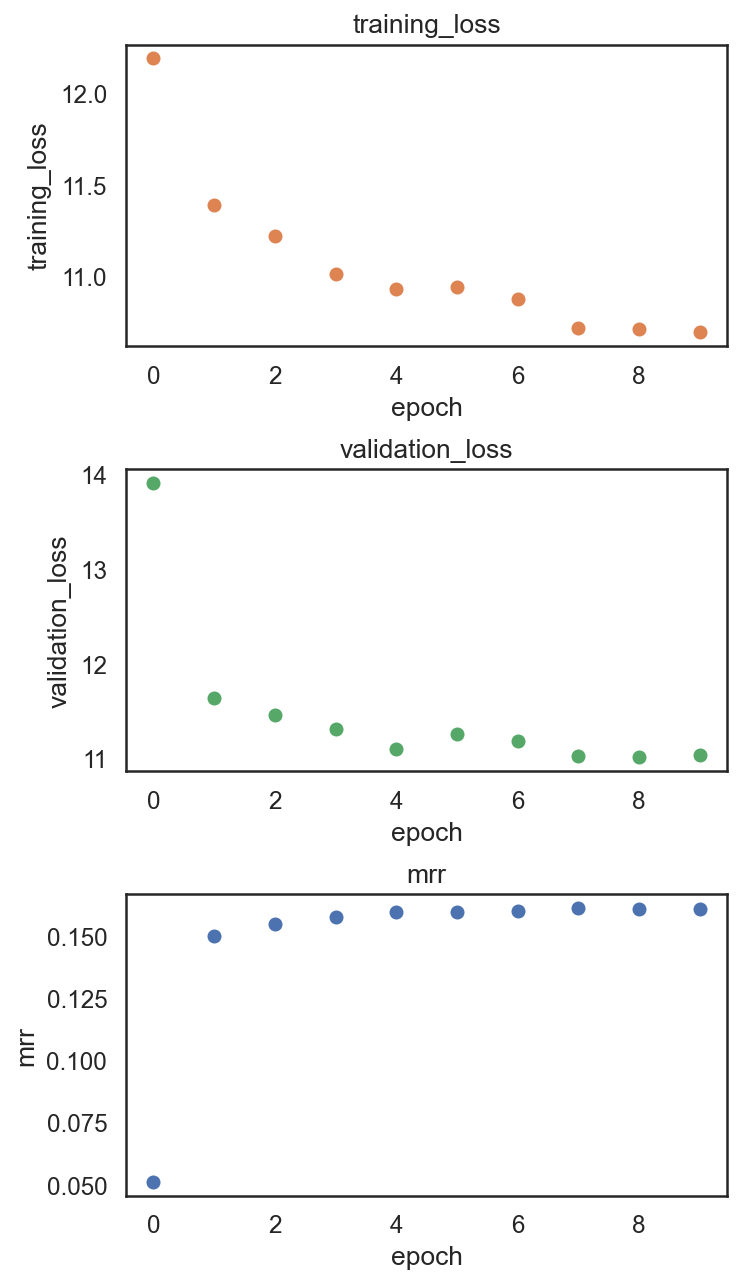

In [21]:
si.pl.pbg_metrics(fig_ncol=1)

Performing softmax transformation for query data 0;


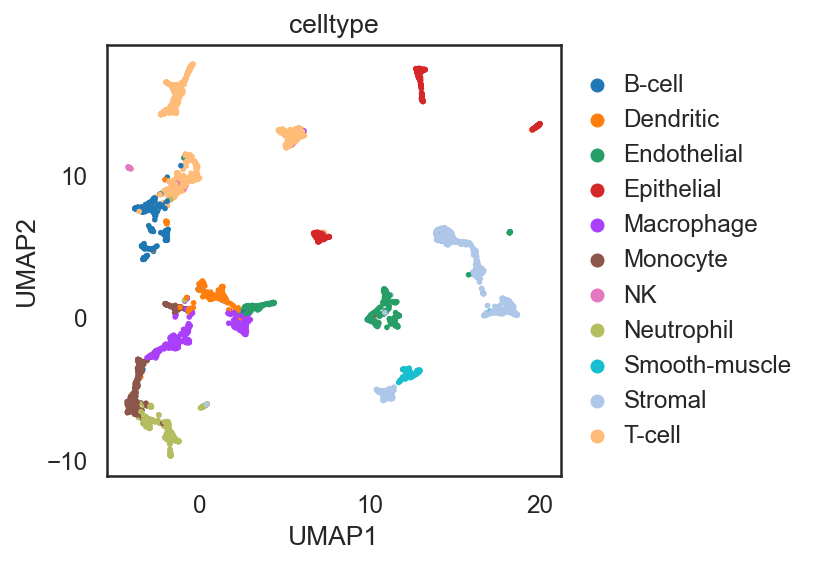

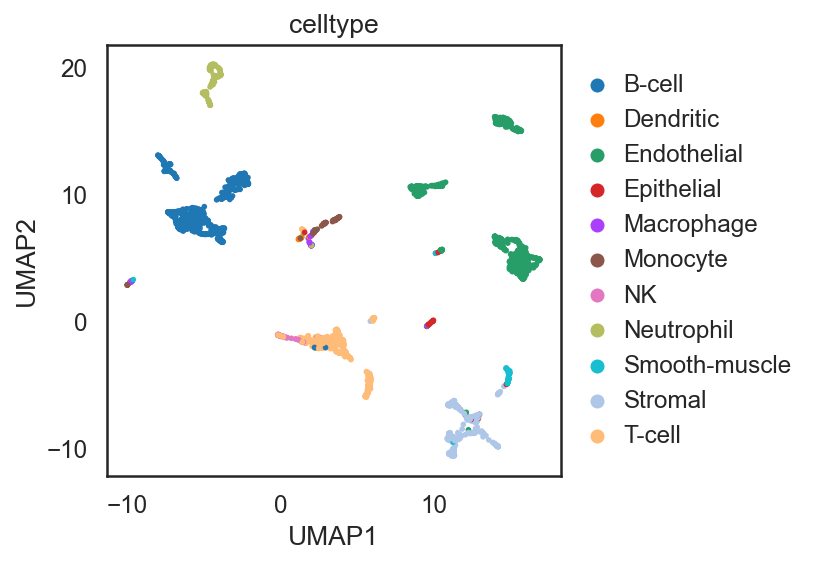

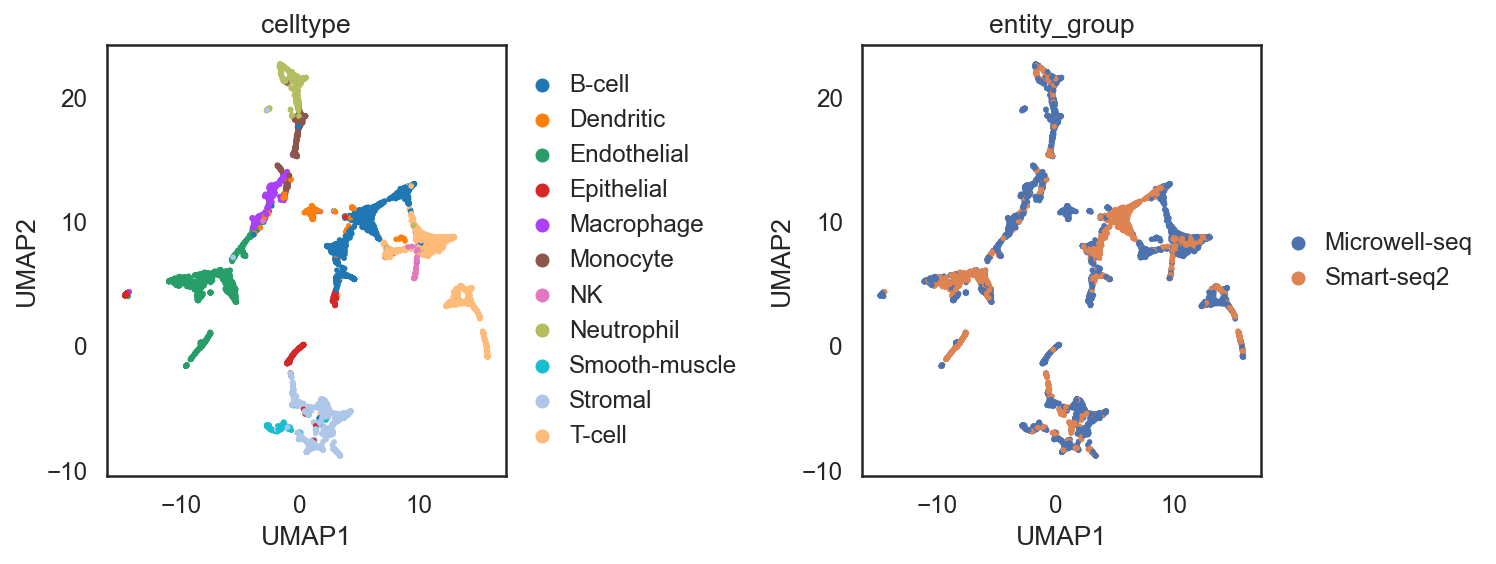

In [22]:
dict_adata = si.read_embedding()
adata_C = dict_adata['E0']  # embeddings of cells from mirowell-seq data
adata_C2 = dict_adata['E2']  # embeddings for cells from smart-seq data
adata_G = dict_adata['E1']  # embeddings for genes

## Add annotation of celltypes (optional)
adata_C.obs['celltype'] = adata_CG_mi[adata_C.obs_names,:].obs['celltype'].copy()
si.tl.umap(adata_C,n_neighbors=15,n_components=2)

## Add annotation of celltypes (optional)
adata_C2.obs['celltype'] = adata_CG_sm[adata_C2.obs_names,:].obs['celltype'].copy()
si.tl.umap(adata_C2,n_neighbors=15,n_components=2)

adata_all = si.tl.embed(adata_ref=adata_C,list_adata_query=[adata_C2])

## add annotations of two batches
adata_all.obs['entity_group'] = ""
adata_all.obs.loc[adata_C.obs_names, 'entity_group'] = "Microwell-seq"
adata_all.obs.loc[adata_C2.obs_names, 'entity_group'] = "Smart-seq2"

adata_all.obs.head()
si.tl.umap(adata_all,n_neighbors=15,n_components=2)

si.pl.umap(adata_C,
           color=['celltype'],
           fig_size=(5.5, 4),
           drawing_order='random')

si.pl.umap(adata_C2,
           color=['celltype'],
           fig_size=(5.5, 4),
           drawing_order='random')

si.pl.umap(adata_all,color=['celltype','entity_group'],
           drawing_order='random',
           fig_size=(5,4))